<a href="https://colab.research.google.com/github/dru-44/PDA/blob/main/Covid_19_dataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating Current Cases by Category
This notebook explores a methodology to estimate current mild, severe and critical patients. Both mild and critical categories appear to be correlated to independently reported categories from Italy's ministry of health.

Most of the reporting of COVID-19 data, including what is reported by the ECDC, focuses on the daily counts of new cases and deaths. While this is useful for tracking the general development of the disease, it provides little information about the capacity required by a health care system to cope with the case load. Here we explore a methodology to estimate total active cases (cases between onset and recovery / death) broken down by category.

### Breakdown of cases
Early data from China classified the cases into *mild*, *severe* and *critical* with 80.9%, 13.8% and 4.7% of occurrences respectively ([source](https://www.cnn.com/2020/03/20/health/covid-19-recovery-rates-intl/index.html)). While this might be useful for categorising cases, it does not appear to match some outcome-based data like hospitalization rate where, as of March 26, Italy reported 43.2%, Spain 56.80% and New York 15% of all confirmed cases.

Such wild range in hospitalization rates is potentially due to different criteria being used across health care systems as well as hitting potential system capacity limits. Therefore, the estimations performed here cannot be used as a proxy for hospitalization rates unless a country-dependent correcting factor is applied. However, using an estimate of 5% of all cases appears to be a good predictor for ICU admission rates, and 15% of all cases seem to correlate to a rate of confirmed cases that only experience mild symptoms.

In [1]:
# Since reported numbers are approximate, they are rounded for the sake of simplicity
severe_ratio = .15
critical_ratio = .05
mild_ratio = 1 - severe_ratio - critical_ratio

### Discharge time for severe vs critical cases
Unfortunately, early data from Chinese sources only reported a median stay of 12 and a mean stay of 12.8 for *all hospitalizations* without specifying which of them required ICU resources.

Since we know the ratio of severe vs critical cases, we only need to guess the discharge time of severe cases since there will only be one way to satisfy the constraint of overall hospitalization median and mean. Here, we plot the estimated discharge time for critical cases (y axis) given a discharge time for severe cases (x axis):

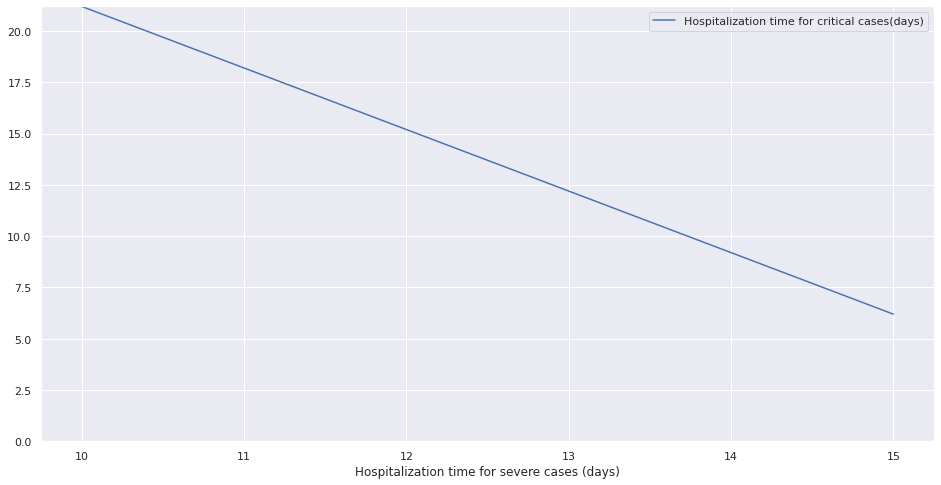

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

# Data from early Chinese reports
mean_discharge_time = 12.8
severe_ratio_norm = severe_ratio / (severe_ratio + critical_ratio) 
critical_ratio_norm = critical_ratio / (severe_ratio + critical_ratio) 

def compute_icu_discharge_time(severe_discharge_time, mean_discharge_time: float = 12.8):
    ''' Using mean discharge time from https://www.cnn.com/2020/03/20/health/covid-19-recovery-rates-intl/index.html '''
    return (mean_discharge_time - severe_discharge_time * severe_ratio_norm) / critical_ratio_norm

X = np.linspace(10, 15, 100)
y = np.array([compute_icu_discharge_time(x) for x in X])

X_name = 'Hospitalization time for severe cases (days)'
y_name = 'Hospitalization time for critical cases(days)'
df = pd.DataFrame([(x, y_) for x, y_ in zip(X, y)], columns=[X_name, y_name]).set_index(X_name)
df.plot(figsize=(16, 8), grid=True, ylim=(0, max(y)));

Because the data is reported daily, we can only pick an estimated whole number for both variables. The only possible value for *hospital discharge days* that would result in a median discharge time of 12 days is, unsurprisingly, 12. Then, the estimated *ICU discharge days* is 15 days.

In [3]:
severe_recovery_days = 12
critical_recovery_days = 15

### Recovery time for mild cases
In order to estimate the current number of mild cases, there is one more number that we must guess: how many days it takes for recovery, on average, for all cases that are not severe or critical. Reported recovery times from a COVID-19 infection range from 2 weeks ([source](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)) to "a week to 10 days" ([source](https://www.webmd.com/lung/news/20200324/the-other-side-of-covid-19-milder-cases-recovery#1)). After experimenting with several choices, using a median recovery time of 7 days appears to match empirical data from multiple official reports.

In [4]:
mild_recovery_days = 7

### Estimating new cases breakdown
Using Italy's data up to March 26, assuming the proportion of each category remains constant for every new case, daily breakdowns can be estimated by multiplying the number of new cases by the ratios of the respective categories:

In [5]:
import pandas as pd

# Load country-level data for Italy
data = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/IT/main.csv').set_index('date')

# Estimate daily counts per category assuming ratio is constant
data = data[data.index <= '2020-03-27']
data['new_mild'] = data['new_confirmed'] * mild_ratio
data['new_severe'] = data['new_confirmed'] * severe_ratio
data['new_critical'] = data['new_confirmed'] * critical_ratio
data = data[['new_confirmed', 'new_deceased', 'new_mild', 'new_severe', 'new_critical']]

data.tail(7)

,new_confirmed,new_deceased,new_mild,new_severe,new_critical
date,,,,,
2020-03-21,6557.0,793.0,5245.6,983.55,327.85
2020-03-22,5560.0,651.0,4448.0,834.00,278.00
2020-03-23,4789.0,601.0,3831.2,718.35,239.45
2020-03-24,5249.0,743.0,4199.2,787.35,262.45
2020-03-25,5210.0,683.0,4168.0,781.50,260.50
2020-03-26,6153.0,662.0,4922.4,922.95,307.65
2020-03-27,5959.0,969.0,4767.2,893.85,297.95


### Estimating current cases breakdown
Now that we have an estimate for the category breakdown of new cases as well as for the discharge time per category, we can estimate the number of current cases per category by adding up each category over a rolling window:

In [6]:
data['current_mild'] = data['new_mild'].rolling(round(mild_recovery_days)).sum()
data['current_severe'] = data['new_severe'].rolling(round(severe_recovery_days)).sum()
data['current_critical'] = data['new_critical'].rolling(round(critical_recovery_days)).sum()
data.tail(7)

,new_confirmed,new_deceased,new_mild,new_severe,new_critical,current_mild,current_severe,current_critical
date,,,,,,,,
2020-03-21,6557.0,793.0,5245.6,983.55,327.85,25936.8,6660.90,2447.10
2020-03-22,5560.0,651.0,4448.0,834.00,278.00,27512.8,7348.35,2662.75
2020-03-23,4789.0,601.0,3831.2,718.35,239.45,28757.6,7719.75,2827.60
2020-03-24,5249.0,743.0,4199.2,787.35,262.45,30136.0,8109.45,3000.20
2020-03-25,5210.0,683.0,4168.0,781.50,260.50,30938.4,8508.90,3211.85
2020-03-26,6153.0,662.0,4922.4,922.95,307.65,31603.2,8907.30,3403.85
2020-03-27,5959.0,969.0,4767.2,893.85,297.95,31581.6,9262.65,3569.25


### Comparing with Italy's home care, hospitalizations and ICU counts
Italy categorises the cases into home care, hospitalizations and ICU admission, which appear to map well into *mild*, *severe* and *critical* categories. From Italy's ministry of health, this is the breakdown [as of March 26](https://web.archive.org/web/20200325181518/http://www.salute.gov.it/portale/nuovocoronavirus/dettaglioContenutiNuovoCoronavirus.jsp?lingua=italiano&id=5351&area=nuovoCoronavirus&menu=vuoto) of cases compared to our model estimates:

In [7]:
estimated = data.iloc[-1]
reported = pd.DataFrame.from_records([
    {'Category': 'current_mild', 'Count': 30920},
    {'Category': 'current_severe', 'Count': 23112},
    {'Category': 'current_critical', 'Count': 3489},
]).set_index('Category')

pd.DataFrame.from_records([
    {
        'Category': col, 
        'Estimated': '{0:.02f}'.format(estimated[col]),
        'Reported': reported.loc[col, 'Count'],
        'Difference': '{0:.02f}%'.format(100.0 * (estimated[col]  - reported.loc[col, 'Count']) / reported.loc[col, 'Count']),
    }
    for col in reported.index.tolist()
]).set_index('Category')

,Estimated,Reported,Difference
Category,,,
current_mild,31581.60,30920,2.14%
current_severe,9262.65,23112,-59.92%
current_critical,3569.25,3489,2.30%


While the severe category does not match what was estimated by the model, both mild cases and critical cases were very accurate predictors for home care and ICU patients, respectively.